### Clustering using Hash functions
Trying to implement strand isolation using purely Hash functions. Want to select the same strands together after signatures using some similarity metric

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
from aligned_clustering import conduct_align_clustering
from utils import get_fastq_records, load_json_file, get_original_strands, get_badread_strand_id, get_recovery_percentage

In [145]:
records_original = get_fastq_records(r"C:\Users\Parv\Doc\RA\Projects\incomplete_cycles\v2\runs\2025-01-30 21.21.00.463318\reads_no_adapters.fastq")
#records_original = get_fastq_records(r"C:\Users\Parv\Doc\RA\Projects\incomplete_cycles\v2\runs\2025-01-30 21.21.00.463318\reads_0.98.fastq")

In [146]:
original_strand_ids, coupling_rates, capping_flags, original_strands = get_original_strands(r"C:\Users\Parv\Doc\RA\Projects\incomplete_cycles\v2\runs\2025-01-30 21.21.00.463318\original_strands.txt")

strand_ids_synthesized = load_json_file(r"C:\Users\Parv\Doc\RA\Projects\incomplete_cycles\v2\runs\2025-01-30 21.21.00.463318\synthesized_uid_reference.json")

In [147]:
records = [i for i in records_original if get_badread_strand_id(i) in strand_ids_synthesized]
sequenced_strands = [str(i.seq) for i in records]
strand_ids_sequenced = [get_badread_strand_id(i) for i in records]

So we now have a bunch of strands, and their corresponding original strands. Let's turn them all into kmers

In [148]:
def kmerDNA(seq, k=3):
    kmer = []
    kmer_representation = np.zeros(64)
    for ell in range(len(seq) - k + 1):
        nstr = seq[ell: ell+k]
        index = 0
        for j, c in enumerate(nstr):
            if c == 'A':
                i = 0
            elif c == 'C':
                i = 1
            elif c == 'G':
                i = 2
            elif c == 'T':
                i = 3
            else:
                index = -1
                break
            index += i*(4**j)
        kmer_representation[index] += 1

    return kmer_representation

In [149]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.feature_extraction.text import TfidfTransformer
from collections import Counter

data = [kmerDNA(i) for i in sequenced_strands]
data = normalize(data, norm='l1', axis=1)


tfidf_transformer = TfidfTransformer()
data = tfidf_transformer.fit_transform(data).toarray()
print(len(data))
#scaler = StandardScaler()
#z_score_norm = scaler.fit_transform(data)
#inertias = []

# elbow is where the inertia becomes linear
n_clusters = 10
kmeans = KMeans(n_clusters)
res = kmeans.fit(data)
clusters = [[] for i in range(n_clusters)]
strand_clusters = [[] for i in range(n_clusters)]

for ind, cluster in enumerate(res.labels_):
    clusters[cluster].append(strand_ids_synthesized[strand_ids_sequenced[ind]])
    strand_clusters[cluster].append(sequenced_strands[ind])

[Counter(i) for i in clusters]

417


[Counter({'5fa790b2-b889-4e80-9a10-630305f75b0e': 41}),
 Counter({'8206e19d-8964-464e-b094-7e3925dcf643': 44,
          'd9567e5e-43d3-4869-946e-5832193a26ca': 1}),
 Counter({'3580071c-3bf0-4bb3-9e92-a981fa95db68': 48}),
 Counter({'5fa790b2-b889-4e80-9a10-630305f75b0e': 39}),
 Counter({'3580071c-3bf0-4bb3-9e92-a981fa95db68': 48}),
 Counter({'d9567e5e-43d3-4869-946e-5832193a26ca': 35}),
 Counter({'8bcdba4b-8e73-4909-9d48-1ed937b81bde': 44}),
 Counter({'8bcdba4b-8e73-4909-9d48-1ed937b81bde': 46}),
 Counter({'d9567e5e-43d3-4869-946e-5832193a26ca': 35}),
 Counter({'8206e19d-8964-464e-b094-7e3925dcf643': 36})]

In [150]:
original_strand_ids

['d9567e5e-43d3-4869-946e-5832193a26ca',
 '5fa790b2-b889-4e80-9a10-630305f75b0e',
 '8bcdba4b-8e73-4909-9d48-1ed937b81bde',
 '3580071c-3bf0-4bb3-9e92-a981fa95db68',
 '8206e19d-8964-464e-b094-7e3925dcf643']

In [151]:
# Try on larger data pool - some metric to quantify uniqueness in each cluster
# And then we need to merge somehow
from aligned_clustering import multiple_alignment_muscle
from cluster_merging import majority_merge
from utils import get_recovery_percentage

original_strand = original_strands[2]
cluster_strands = strand_clusters[1]

In [152]:
# Let us try aggregation first. Select one cluster and use Muscle and voting
original_strand

'TGACAACTGAAATTCCAGCGAAGCGCGGGCATGACATAGCACCCGAACCCATAAATTCTGCTACCACAGTATCGTAGAACAACTAAATCGGTGACGTGCTTATAGCGACCGCGTACACGCCTCATGGCCACACGCGAGCCCAGAGCGAGTCACGTAATTTACGGTCCCTAAGTTTGTTGTTTTTACCAGCAGGTACAATC'

In [153]:
print(f"Baseline voting percentage {get_recovery_percentage(majority_merge(strand_clusters[0]), original_strand)}")

Baseline voting percentage 0.245


In [154]:
for i in cluster_strands:
    print(align(i, original_strand).counts[0])

TypeError: 'method' object is not subscriptable

In [155]:
import random

"""
for i in range(20):
    strand_picks = random.sample(cluster_strands, 15)
    muscled = multiple_alignment_muscle(strand_picks)
    aligned_consensus = majority_merge(muscled)
    print(get_recovery_percentage(aligned_consensus, original_strand))
"""

muscled = multiple_alignment_muscle(cluster_strands)
aligned_consensus = majority_merge(muscled)
print(get_recovery_percentage(aligned_consensus, original_strand))

0.23


In [156]:
import Levenshtein

def count_ids_errors(str1, str2):
    edit_operations = Levenshtein.editops(str1, str2)
    
    insertions = sum(1 for op in edit_operations if op[0] == 'insert')
    deletions = sum(1 for op in edit_operations if op[0] == 'delete')
    substitutions = sum(1 for op in edit_operations if op[0] == 'replace')

    return {'Insertions': insertions, 'Deletions': deletions, 'Substitutions': substitutions}

identities = []
mismatches = []

for i in cluster_strands:
    print(count_ids_errors(i, original_strand))

{'Insertions': 29, 'Deletions': 26, 'Substitutions': 53}
{'Insertions': 31, 'Deletions': 31, 'Substitutions': 48}
{'Insertions': 28, 'Deletions': 24, 'Substitutions': 55}
{'Insertions': 28, 'Deletions': 28, 'Substitutions': 53}
{'Insertions': 28, 'Deletions': 24, 'Substitutions': 55}
{'Insertions': 30, 'Deletions': 29, 'Substitutions': 50}
{'Insertions': 31, 'Deletions': 30, 'Substitutions': 48}
{'Insertions': 30, 'Deletions': 29, 'Substitutions': 49}
{'Insertions': 29, 'Deletions': 30, 'Substitutions': 49}
{'Insertions': 29, 'Deletions': 28, 'Substitutions': 52}
{'Insertions': 32, 'Deletions': 29, 'Substitutions': 48}
{'Insertions': 30, 'Deletions': 27, 'Substitutions': 52}
{'Insertions': 29, 'Deletions': 28, 'Substitutions': 51}
{'Insertions': 29, 'Deletions': 26, 'Substitutions': 52}
{'Insertions': 30, 'Deletions': 27, 'Substitutions': 51}
{'Insertions': 29, 'Deletions': 29, 'Substitutions': 52}
{'Insertions': 28, 'Deletions': 24, 'Substitutions': 53}
{'Insertions': 29, 'Deletions':

In [157]:
!pip install Levenshtein

DEPRECATION: Loading egg at c:\users\parv\anaconda3\envs\pytorch_gpu\lib\site-packages\ont_bonito-0.8.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [158]:

insertions = []
deletions = []
subs = []

for i, j in zip(sequenced_strands, strand_ids_sequenced):
    original_strand = original_strands[original_strand_ids.index(strand_ids_synthesized[j])]
    print(get_recovery_percentage(i, original_strand))

    errs = count_ids_errors(i, original_strand)
    print(errs)
    insertions.append(errs['Insertions'])
    deletions.append(errs['Deletions'])
    subs.append(errs['Substitutions'])
    print()

0.295
{'Insertions': 30, 'Deletions': 33, 'Substitutions': 45}

0.71
{'Insertions': 2, 'Deletions': 0, 'Substitutions': 1}

0.78
{'Insertions': 2, 'Deletions': 1, 'Substitutions': 2}

0.455
{'Insertions': 3, 'Deletions': 1, 'Substitutions': 2}

0.28
{'Insertions': 5, 'Deletions': 1, 'Substitutions': 3}

0.565
{'Insertions': 1, 'Deletions': 0, 'Substitutions': 1}

0.235
{'Insertions': 5, 'Deletions': 0, 'Substitutions': 3}

0.25
{'Insertions': 25, 'Deletions': 21, 'Substitutions': 61}

0.78
{'Insertions': 2, 'Deletions': 2, 'Substitutions': 1}

0.27
{'Insertions': 24, 'Deletions': 22, 'Substitutions': 54}

0.345
{'Insertions': 3, 'Deletions': 0, 'Substitutions': 1}

0.24
{'Insertions': 24, 'Deletions': 24, 'Substitutions': 61}

0.29
{'Insertions': 3, 'Deletions': 1, 'Substitutions': 1}

0.445
{'Insertions': 28, 'Deletions': 3, 'Substitutions': 5}

0.42
{'Insertions': 2, 'Deletions': 1, 'Substitutions': 2}

0.645
{'Insertions': 2, 'Deletions': 0, 'Substitutions': 1}

0.295
{'Insertions':

In [159]:
# Maybe if I turn adapters off?
print(np.mean(deletions)/len(original_strand) * 100)
print(np.mean(insertions)/len(original_strand) * 100)
print(np.mean(subs)/len(original_strand) * 100)

7.380095923261392
7.399280575539569
14.032374100719425


Levenshtien edit distance works pretty well. That's my metric. Kmeans works for now. I'll bring down junk reads etc, remove adapters, and test it again to see how well aggregation works.
Maybe try DBscan with Levenshtien distance

In [160]:

from Levenshtein import ratio

for cluster_strands in strand_clusters:
    for strand in cluster_strands:
        for strand_ in cluster_strands:
            if (strand == strand_):
                continue
            print(ratio(strand, strand_))
        print()    

0.9797979797979798
0.9849246231155779
0.9696969696969697
0.9722921914357683
0.9774436090225564
0.9748743718592965
0.9744897959183674
0.9747474747474747
0.9465648854961832
0.9772151898734177
0.982367758186398
0.9821882951653944
0.9591836734693877
0.9620253164556962
0.975
0.9822784810126582
0.9693877551020408
0.9772151898734177
0.9847715736040609
0.9721518987341772
0.9773299748110831
0.9567430025445293
0.9056603773584906
0.9848484848484849
0.9797979797979798
0.958974358974359
0.9772151898734177
0.9796954314720813
0.9772151898734177
0.9438775510204082
0.9698492462311558
0.9797979797979798
0.9646464646464646
0.9770992366412213
0.9672544080604534
0.9797979797979798
0.9798994974874372
0.9796954314720813
0.9720101781170484
0.9722921914357683

0.9797979797979798
0.9800995024875622
0.97
0.972568578553616
0.9826302729528535
0.9751243781094527
0.9747474747474747
0.975
0.947103274559194
0.9724310776942355
0.9825436408977556
0.9672544080604534
0.9646464646464646
0.9624060150375939
0.975247524752475

In [161]:
print(res.labels_)

[9 8 4 6 6 3 6 0 4 5 1 0 4 4 8 4 9 1 8 2 1 2 7 1 2 3 6 6 5 2 7 8 0 1 4 4 7
 6 8 1 6 2 2 4 2 4 5 5 1 3 4 9 6 1 4 3 3 4 6 2 3 0 0 7 9 5 8 9 7 2 0 2 8 6
 1 0 9 0 8 7 4 1 5 0 9 9 3 0 9 6 5 1 9 2 4 2 6 6 2 3 0 0 2 9 6 8 5 9 1 7 6
 2 3 3 7 3 3 6 7 3 0 8 1 4 2 1 7 2 3 0 1 9 0 9 1 8 0 1 5 4 0 9 8 3 3 3 8 2
 2 7 1 1 7 6 2 6 0 9 5 5 9 6 8 0 0 2 6 1 2 3 2 6 6 7 8 1 9 2 8 0 9 9 3 1 3
 3 0 9 4 6 1 1 4 5 9 3 6 5 7 6 4 4 3 1 3 3 2 7 8 0 3 7 4 7 5 9 7 5 8 2 4 2
 1 8 5 2 1 0 7 6 3 8 1 6 1 9 4 2 4 2 8 0 9 4 9 6 5 6 5 6 2 9 1 5 9 6 2 6 8
 7 0 4 5 4 1 5 3 7 8 1 8 4 5 6 3 0 3 9 4 7 0 7 6 3 8 7 4 4 7 2 4 8 5 9 2 4
 1 7 6 1 1 6 0 9 1 5 7 5 2 0 6 6 2 7 7 0 8 2 7 4 7 5 7 8 1 4 3 3 2 7 2 3 7
 4 4 3 6 8 1 1 7 9 0 0 0 7 5 4 2 9 7 5 2 4 4 0 1 7 9 7 3 0 5 9 4 2 0 8 4 4
 6 8 1 6 2 4 5 0 4 8 6 8 5 2 5 1 1 2 4 9 6 3 0 8 7 1 1 5 7 0 4 6 7 2 2 5 0
 5 3 7 2 7 8 3 7 7 4]


In [162]:

sequenced_strands_set = set()
for i in sequenced_strands:
    for j in sequenced_strands:
        if not i==j:
            if ratio(i, j) > 0.96:
                sequenced_strands_set.add(i)
                sequenced_strands_set.add(j)

In [163]:
len(sequenced_strands_set)

390

In [164]:
ss = list(sequenced_strands_set)

(array([ 1.,  5., 22., 34., 59., 78., 94., 57., 29., 11.]),
 array([194., 195., 196., 197., 198., 199., 200., 201., 202., 203., 204.]),
 <BarContainer object of 10 artists>)

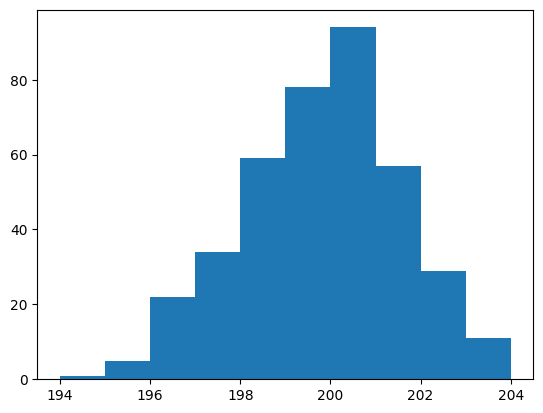

In [165]:
plt.hist([len(i) for i in ss])

In [166]:
import Levenshtein
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

def compute_distance_matrix(strands):
    n = len(strands)
    distance_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            distance = Levenshtein.distance(strands[i], strands[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  # Symmetric matrix
    
    return distance_matrix

def cluster_strands(strands, method='ward', threshold=2):
    distance_matrix = compute_distance_matrix(strands)
    
    # Convert to condensed form for hierarchical clustering
    condensed_matrix = sch.distance.squareform(distance_matrix)
    
    # Perform hierarchical clustering
    linkage_matrix = sch.linkage(condensed_matrix, method=method)
    
    # Retrieve clusters
    clusters = sch.fcluster(linkage_matrix, t=threshold, criterion='distance')
    
    # Map clusters to strand names
    clustered_strands = {}
    for strand, cluster in zip(strands, clusters):
        if cluster not in clustered_strands:
            clustered_strands[cluster] = []
        clustered_strands[cluster].append(strand)
    
    return clustered_strands

# Example strands
strands = ["AGCT", "AGC", "AGT", "TGCA", "GCTA", "CGTA"]

# Perform clustering and retrieve clusters
clusters = list(cluster_strands(ss, threshold=500).values())
len(clusters)


10

In [180]:

for i in clusters[2]:
    for j in original_strands:
        print(ratio(i, j))

    print()


cluster_strands = clusters[2]
original_strand = original_strands[1]

0.6365914786967419
0.987468671679198
0.6265664160401003
0.631578947368421
0.631578947368421

0.6363636363636364
0.98989898989899
0.6363636363636364
0.6363636363636364
0.6262626262626263

0.6347607052896725
0.9773299748110831
0.6347607052896725
0.6347607052896725
0.6297229219143576

0.631578947368421
0.9924812030075187
0.631578947368421
0.631578947368421
0.6265664160401003

0.6334164588528679
0.9775561097256857
0.6334164588528679
0.6234413965087282
0.6384039900249376

0.6281407035175879
0.9849246231155779
0.6381909547738693
0.6281407035175879
0.6281407035175879

0.6397984886649875
0.9722921914357683
0.6297229219143576
0.619647355163728
0.6246851385390428

0.6284289276807979
0.9875311720698254
0.6284289276807979
0.6334164588528679
0.6184538653366584

0.6397984886649875
0.982367758186398
0.6297229219143576
0.619647355163728
0.6347607052896725

0.635
0.985
0.63
0.625
0.625

0.6416040100250626
0.9824561403508771
0.6365914786967419
0.631578947368421
0.6265664160401003

0.635
0.99
0.63
0.625


In [181]:

for i in range(10):
    muscled = multiple_alignment_muscle(random.sample(cluster_strands, 10))
    aligned_consensus = majority_merge(muscled)
    print(get_recovery_percentage(aligned_consensus, original_strands[1]))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [169]:
aligned_consensus

'CACGGCTCCTAGCAGTAGACGACAAACTCCGGGGTATAAGCAATATACAGGAACTGCGGGAATCAAGGGTGTTCAGCACAAATGCTGCCTACCATGCTATGTTTTATTAGAGGTCACTAAGCAGACCTCCTGGGTTTTTTACGTGAGAGCTTATGCTCGGACTTTGCCATTGTGTGCTTATCGCCTGCCGTTGAGGACGA'

In [170]:
original_strands[4]

'TTTCAGTCTGTGCGAGTGACAGATCAATCCCACCCCGCAGGTTCCTTAGTCAGATGTAAATACGACCCGGGTGTGAGTACTGTACTGAGTACTCAGTGGAACCCTCTGGAGAGGGAGCTTGCACATTGAAACAAATCATTCTTCACCCATTACGGAGTCCAGGCGCTCGTAGCTGGCACGCTTGCCGTAATAAGCGAACA'

In [171]:

from seq_stat import align

align(aligned_consensus, original_strands[4]).counts()

AlignmentCounts(gaps=123, identities=130, mismatches=7)

In [193]:
print(len(clusters))

10


In [189]:

found = set()

for i in clusters:
    muscled = multiple_alignment_muscle(i)
    aligned_consensus = majority_merge(muscled)
    for c, original_strand in enumerate(original_strands):
        if get_recovery_percentage(aligned_consensus, original_strand) == 1.0:
            print("I was found")
            found.add(c)
    print()

I was found

I was found

I was found



I was found




I was found



In [190]:
# You actually don't need that many repeats at all - but adapters will fuck you up
print(found)

{0, 1, 2, 3, 4}
